In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 160

from toolbox import Preprocessing, Settings, VideoAnalysis, Visualize
from toolbox import Sampling, PredictionSample, IntervalSample

In [2]:
dataFile = Preprocessing.listDataFiles(excludeDataWithoutMovies=True)

propertyFile = Preprocessing.loadRunData(dataFile)
video = Preprocessing.loadVideo(dataFile)
matFile = Preprocessing.loadMatFile(dataFile)

In [3]:
Sampling.playVideo(video, propertyFile)

345.0

## Interval Sample

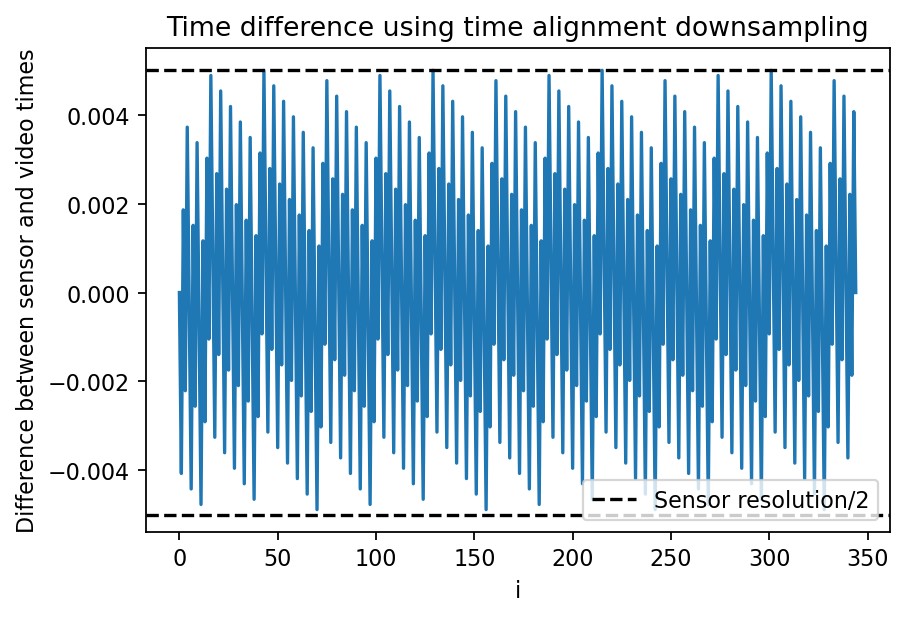

In [10]:
sensorTimeArr = matFile["t"]
sensorForceArr = matFile["f"]
videoTimeArr = VideoAnalysis.timeArr(video, propertyFile)
kernelGuess = int((videoTimeArr[1] - videoTimeArr[0])/Settings.FORCE_SENSOR_DT)

downsampledTimeArr = Sampling.timeAlignmentDownsample(sensorTimeArr, sensorForceArr, videoTimeArr, kernelGuess, debug=True)[0]

#print(downsampledTimeArr)
plt.plot(videoTimeArr-downsampledTimeArr)
plt.axhline(y=Settings.FORCE_SENSOR_DT/2, color='black', linestyle='--', label='Sensor resolution/2')
plt.axhline(y=-Settings.FORCE_SENSOR_DT/2, color='black', linestyle='--')

plt.ylabel('Difference between sensor and video times')
plt.xlabel('i')
plt.legend()
plt.title('Time difference using time alignment downsampling')
plt.savefig('images/SamplingTest_images/downsample_time_error2.png')
plt.show()

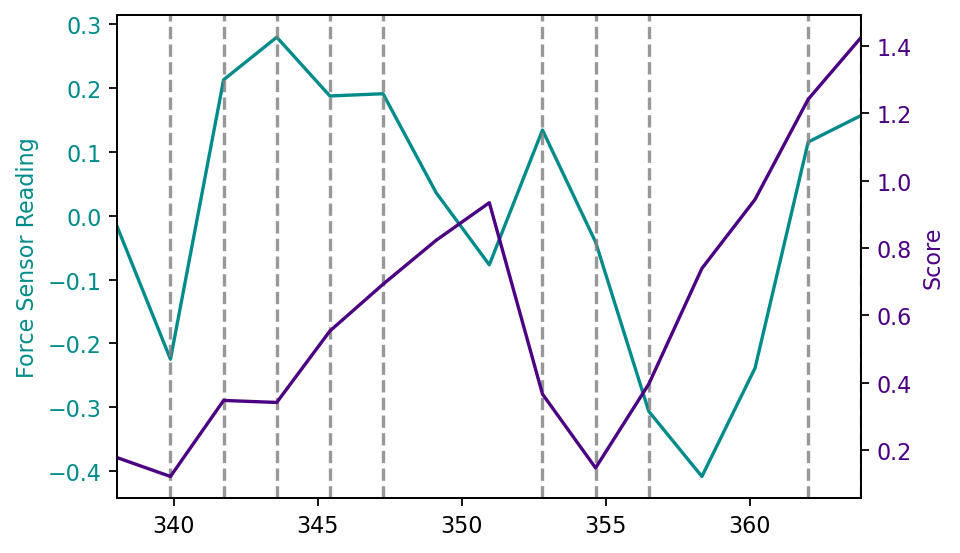

{'name': '070330b', 'velocity': 0.05, 'shearspringname': 'D', 'normalspringname': '#1', 'boundary': '', 'starttime': 15.0, 'endtime': 650.0, 'fps': 4.0, 'pixpermm': 1.8, 'type': "{'creep'}", 'goodarea': array([ 90, 697,  79, 493]), 'centerline': 270.0, 'numpart': 'N'}


In [15]:
samples = IntervalSample.randomIntervalSample(video, propertyFile, matFile, VideoAnalysis.averageBrightness, interpolate=True, numSamples=2, sampleLength=15)
#Sampling.visualizeSample(tArr=samples[0][0], sArr=samples[0][1], fArr=samples[0][2], events=samples[0][3], savePath='SamplingTest_images/test_no_int.png')
Visualize.visualizeSample(sample=samples[0], savePath='images/SamplingTest_images/sample1.png')
#Visualize.visualizeSample(sample=samples[1])

print(propertyFile)

## Prediction Sample

[-1.84593023  0.        ]


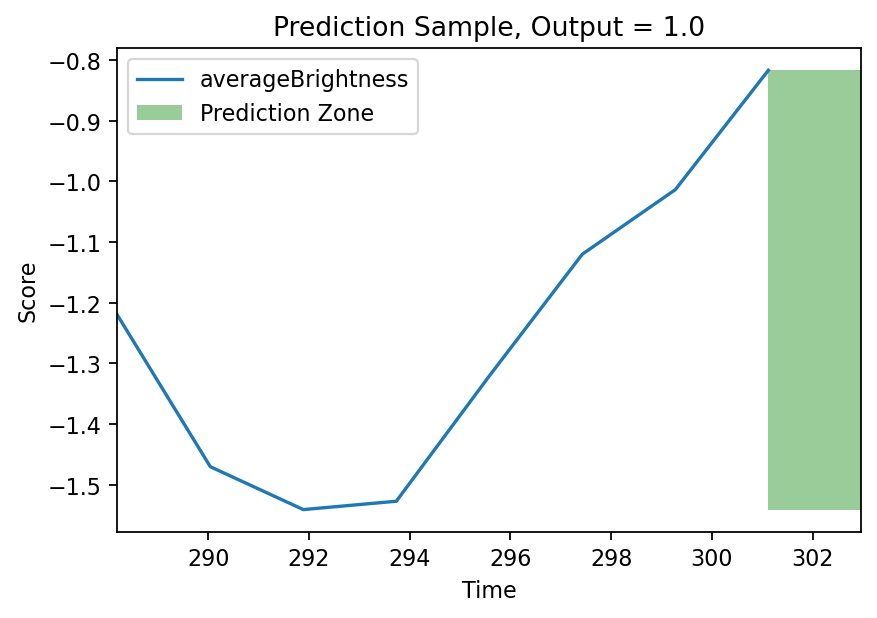

In [8]:
scores = [VideoAnalysis.averageBrightness]
fT = .8
inputs, outputs = PredictionSample.randomPredictionSample(video, propertyFile, matFile, scores, numSamples=1, sampleLength=8, forceEventThreshhold=fT)
dt = inputs[0][1] - inputs[0][0]

peakTimes = [matFile["time"][i] for i in range(len(matFile["time"])) if (bool(matFile["good"][i]) and abs(matFile["deltaF"][i]) > fT)]
for p in peakTimes:
    plt.axvline(p, color='tab:gray', alpha=.8, linewidth=1, linestyle='--')


for i in range(len(scores)):
    plt.plot(inputs[0], inputs[i+1], label=scores[i].__name__)
plt.fill([inputs[0,-1], inputs[0,-1]+dt, inputs[0,-1]+dt, inputs[0,-1]], [min(inputs[1]), min(inputs[1]), max(inputs[1]), max(inputs[1])], 'g', alpha=.4, label="Prediction Zone")

plt.xlim(min(inputs[0]), max(inputs[0])+dt)

plt.title(f'Prediction Sample, Output = {outputs}')

plt.legend()
plt.ylabel("Score")
plt.xlabel("Time")
plt.show()

1.845930232558203
(13, 2, 8)
(13,)


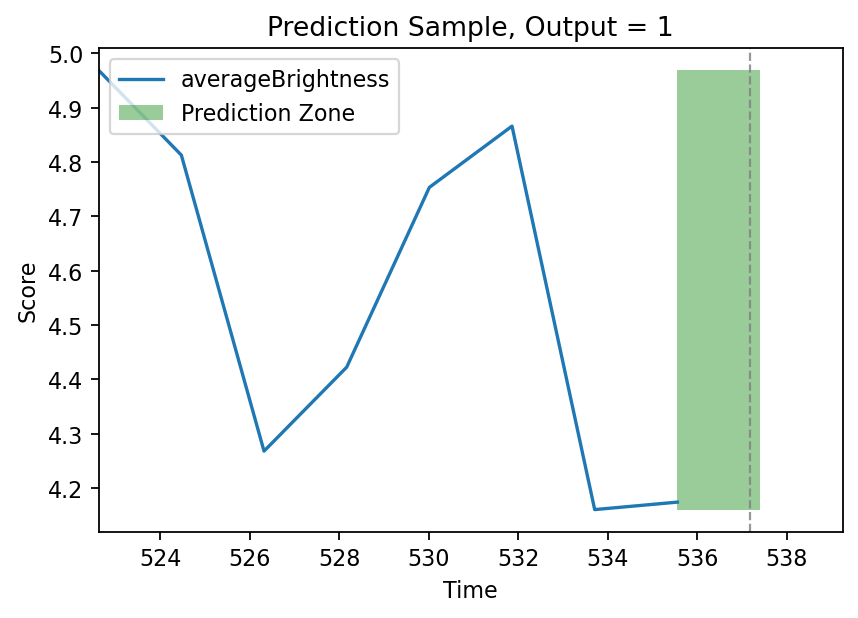

In [16]:
scores = [VideoAnalysis.averageBrightness]
fT = .8
inputs, outputs = PredictionSample.fullPredictionSample(video, propertyFile, matFile, scores, sampleLength=8, forceEventThreshhold=fT)
dt = inputs[0][0][1] - inputs[0][0][0]
print(dt)
print(np.shape(inputs))
print(np.shape(outputs))

index = 3

peakTimes = [matFile["time"][i] for i in range(len(matFile["time"])) if (bool(matFile["good"][i]) and abs(matFile["deltaF"][i]) > fT)]
for p in peakTimes:
    plt.axvline(p, color='tab:gray', alpha=.8, linewidth=1, linestyle='--')

for i in range(len(scores)):
    plt.plot(inputs[index,0], inputs[index,i+1], label=scores[i].__name__)
plt.fill([inputs[index,0,-1], inputs[index,0,-1]+dt, inputs[index,0,-1]+dt, inputs[index,0,-1]], [min(inputs[index,1]), min(inputs[index,1]), max(inputs[index,1]), max(inputs[index,1])], 'g', alpha=.4, label="Prediction Zone")

plt.xlim(min(inputs[index,0]), max(inputs[index,0])+2*dt)

plt.title(f'Prediction Sample, Output = {outputs[index]}')

plt.legend()
plt.ylabel("Score")
plt.xlabel("Time")
plt.savefig('images/SamplingTest_images/prediction_sample_test.png')
plt.show()

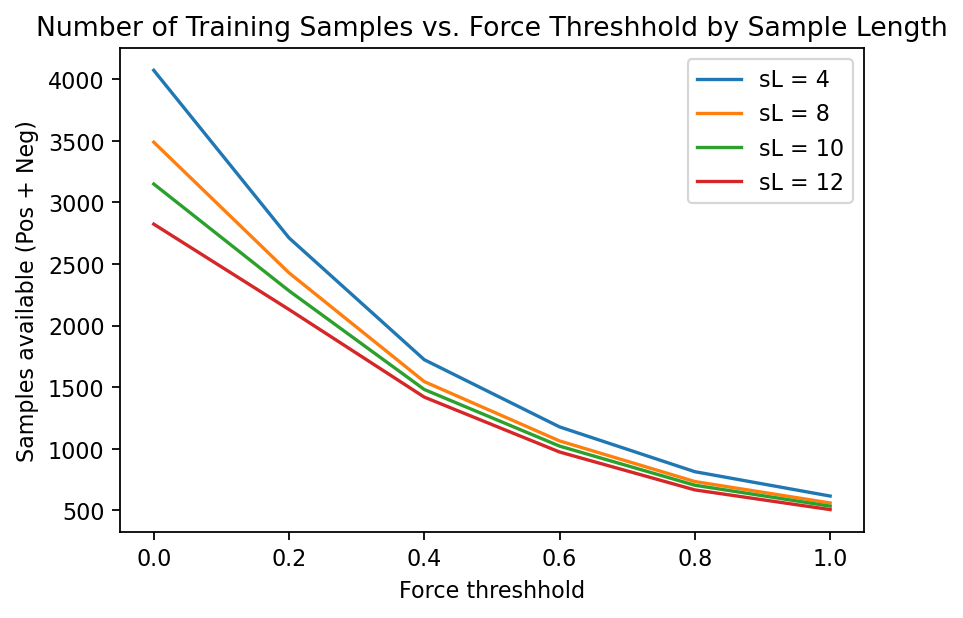

In [8]:
dataFile = Preprocessing.listDataFiles(excludeDataWithoutMovies=True)

propertyFile = Preprocessing.loadRunData(dataFile)
video = Preprocessing.loadVideo(dataFile)
matFile = Preprocessing.loadMatFile(dataFile)

scores = [VideoAnalysis.testFunc]
fTArr = [0, .2, .4, .6, .8, 1.]
sampleLengthArr = [4, 8, 10, 12]

for sL in sampleLengthArr:
    samplesAvailable = np.zeros(len(fTArr))
    
    for i in range(len(fTArr)):
        inputs, outputs = PredictionSample.fullPredictionSample(video, propertyFile, matFile, scores, sampleLength=sL, forceEventThreshhold=fTArr[i])
        samplesAvailable[i] = np.shape(inputs)[0]
        
    plt.plot(fTArr, samplesAvailable, label=f"sL = {sL}")
    
plt.legend()
plt.xlabel('Force threshhold')
plt.ylabel('Samples available (Pos + Neg)')

plt.title("Number of Training Samples vs. Force Threshhold by Sample Length")

plt.savefig('images/SamplingTest_images/training_volume_estimate.png')
plt.show()

(30, 2, 8)
(30,)


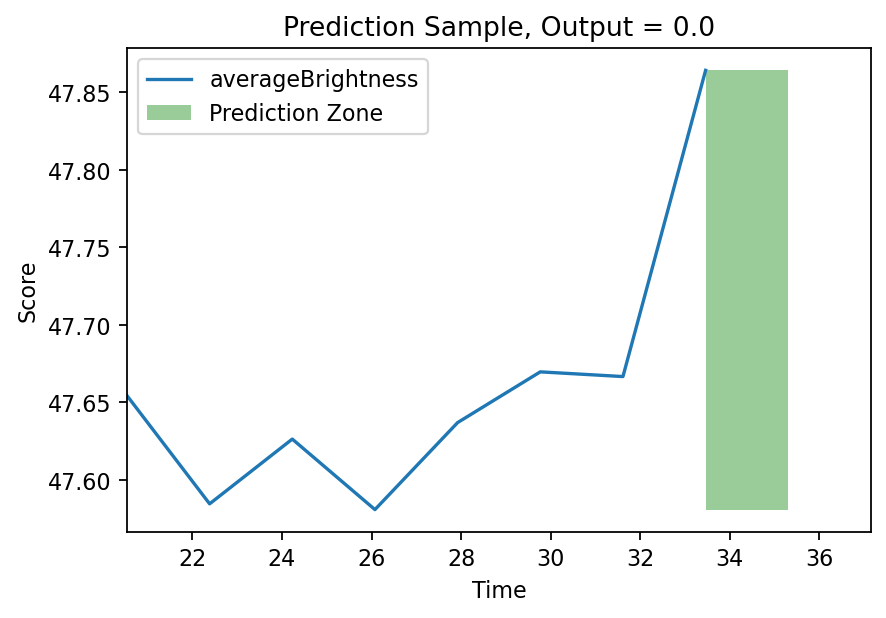

In [9]:
scores = [VideoAnalysis.averageBrightness]
fT = .8
inputs, outputs = PredictionSample.negativePredictionSample(video, propertyFile, matFile, scores, numSamples=30, sampleLength=8, forceEventThreshhold=fT)
dt = inputs[0][0][1] - inputs[0][0][0]
#print(dt)
print(np.shape(inputs))
#print(inputs)
print(np.shape(outputs))
#print(outputs)

index = 0

peakTimes = [matFile["time"][i] for i in range(len(matFile["time"])) if (bool(matFile["good"][i]) and abs(matFile["deltaF"][i]) > fT)]
for p in peakTimes:
    plt.axvline(p, color='tab:gray', alpha=.8, linewidth=1, linestyle='--')

for i in range(len(scores)):
    plt.plot(inputs[index,0], inputs[index,i+1], label=scores[i].__name__)
plt.fill([inputs[index,0,-1], inputs[index,0,-1]+dt, inputs[index,0,-1]+dt, inputs[index,0,-1]], [min(inputs[index,1]), min(inputs[index,1]), max(inputs[index,1]), max(inputs[index,1])], 'g', alpha=.4, label="Prediction Zone")

plt.xlim(min(inputs[index,0]), max(inputs[index,0])+2*dt)

plt.title(f'Prediction Sample, Output = {outputs[index]}')

plt.legend()
plt.ylabel("Score")
plt.xlabel("Time")
plt.savefig('images/SamplingTest_images/prediction_sample_test.png')
plt.show()

In [3]:
# Only works for a single video
scores = [VideoAnalysis.testFunc]
fT = .4
sL = 8

posInputs, posOutputs = PredictionSample.fullPositivePredictionSample(video, propertyFile, matFile, scores, sampleLength=sL, forceEventThreshhold=fT)
negInputs, negOutputs = PredictionSample.negativePredictionSample(video, propertyFile, matFile, scores, numSamples=np.shape(posInputs)[0], sampleLength=sL, forceEventThreshhold=fT)

dt = posInputs[0][0][1] - posInputs[0][0][0]

inputs = np.zeros([np.shape(posInputs)[0]*2, len(scores)+1, sL])
inputs[:np.shape(posInputs)[0],:,:] = posInputs
inputs[np.shape(posInputs)[0]:,:,:] = negInputs
outputs = np.append(posOutputs, negOutputs)

randomOrder = np.arange(0, np.shape(inputs)[0])
np.random.shuffle(randomOrder)

inputs = inputs[randomOrder]
outputs = outputs[randomOrder]

print(np.shape(inputs))

Exception: negativePredictionSample should not be used for multiple videos, use fullPredictionSample instead

In [3]:
# Equivalent to the above code, but done all in one step
scores = [VideoAnalysis.testFunc]
fT = .4
sL = 8

inputs, outputs = PredictionSample.fullPredictionSample(video, propertyFile, matFile, scores, sampleLength=sL, forceEventThreshhold=fT)
print(np.shape(inputs))
print(inputs)

[[[496.7877907  498.63372093 500.47965116 502.3255814  504.17151163
   506.01744186 507.86337209 509.70930233]
  [  1.           1.           1.           1.           1.
     1.           1.           1.        ]]

 [[ 15.          16.84593023  18.69186047  20.5377907   22.38372093
    24.22965116  26.0755814   27.92151163]
  [  1.           1.           1.           1.           1.
     1.           1.           1.        ]]

 [[214.36046512 216.20639535 218.05232558 219.89825581 221.74418605
   223.59011628 225.43604651 227.28197674]
  [  1.           1.           1.           1.           1.
     1.           1.           1.        ]]

 [[ 37.15116279  38.99709302  40.84302326  42.68895349  44.53488372
    46.38081395  48.22674419  50.07267442]
  [  1.           1.           1.           1.           1.
     1.           1.           1.        ]]

 [[426.64244186 428.48837209 430.33430233 432.18023256 434.02616279
   435.87209302 437.71802326 439.56395349]
  [  1.           1.     

TypeError: list indices must be integers or slices, not str

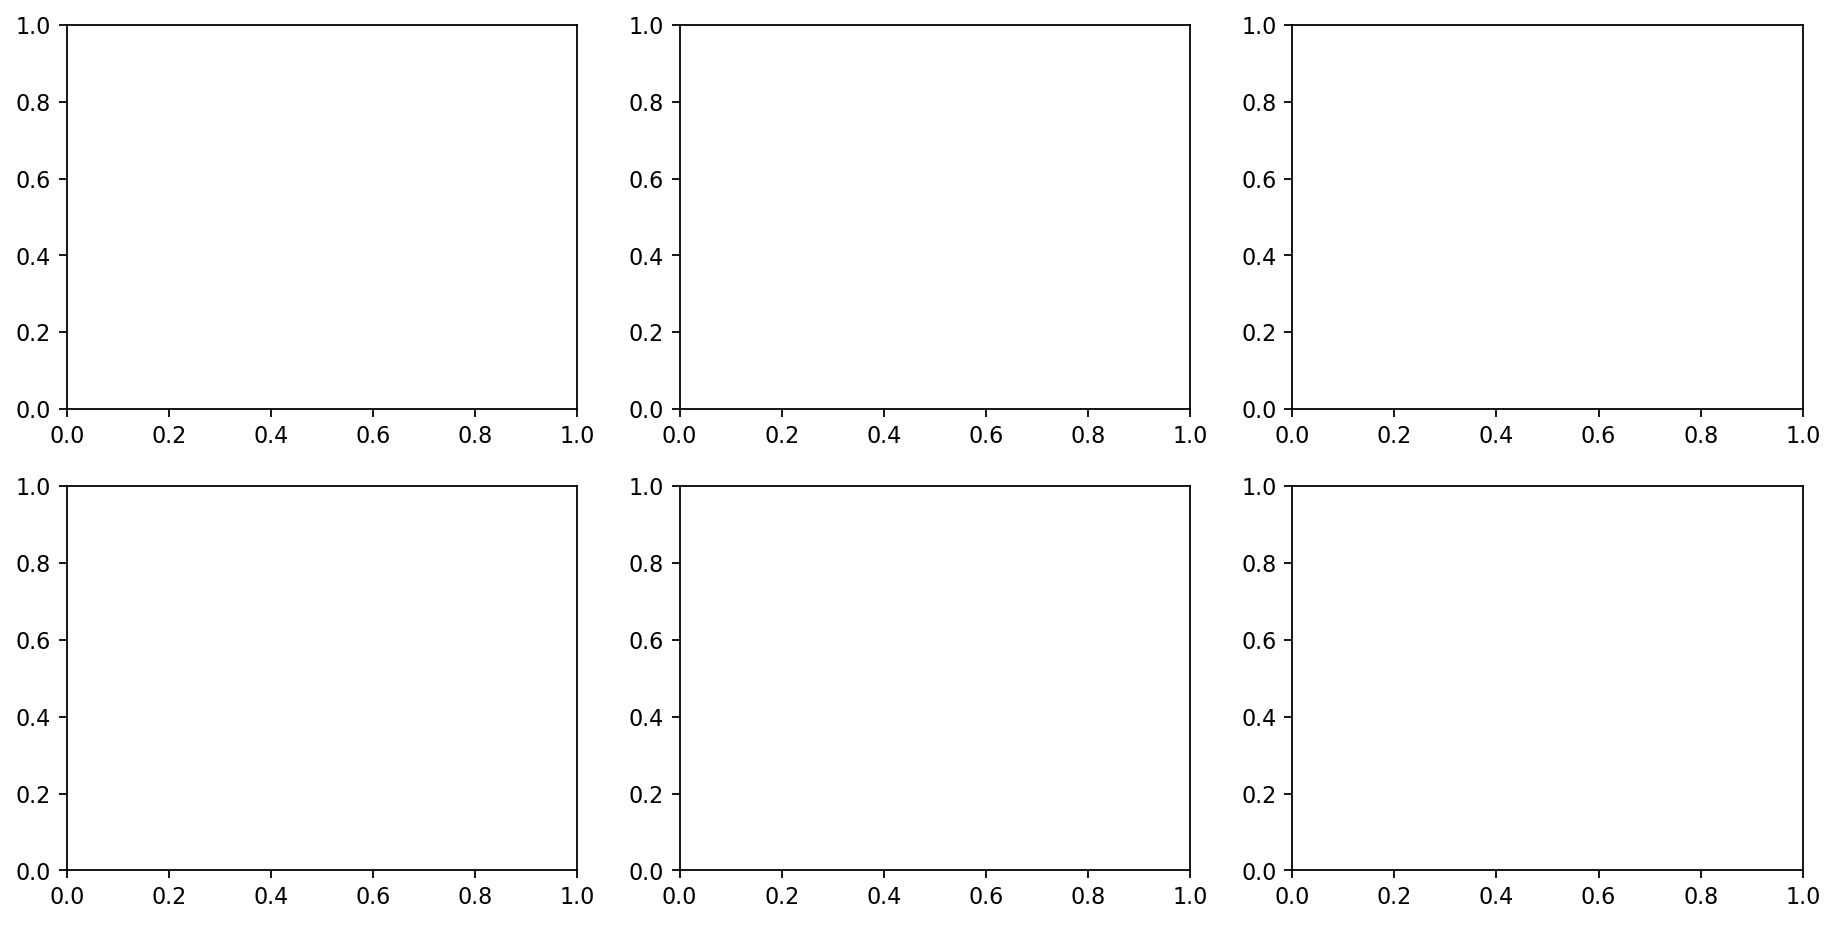

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(14, 7))

peakTimes = [matFile["time"][i] for i in range(len(matFile["time"])) if (bool(matFile["good"][i]) and abs(matFile["deltaF"][i]) > fT)]

for k in range(2):
    for j in range(3):
        for p in peakTimes:
            ax[k,j].axvline(p, color='tab:gray', alpha=.8, linewidth=1, linestyle='--')
            
        index = k*2 + j
        for i in range(len(scores)):
            ax[k,j].plot(inputs[index,0], inputs[index,i+1], label=scores[i].__name__)
        ax[k,j].fill([inputs[index,0,-1], inputs[index,0,-1]+dt, inputs[index,0,-1]+dt, inputs[index,0,-1]], [min(inputs[index,1]), min(inputs[index,1]), max(inputs[index,1]), max(inputs[index,1])], 'g', alpha=.4, label="Prediction Zone")

        ax[k,j].set_xlim(min(inputs[index,0]), max(inputs[index,0])+2*dt)
        ax[k,j].set_title(f"Failure: {bool(outputs[index])}")
        ax[k,j].set_xlabel("Time")
        ax[k,j].legend()
        
fig.tight_layout()
plt.show()